In [3]:
#import openai
import json
import os
#with open("api.key","r") as f:
#    openai.api_key = f.read().strip()



In [4]:
eval_dict={}
eval_dict_path="bayes/results/gpteval/1115.json"
#eval_dict_path="bayes/results/gpteval/1115_35.json"

if os.path.exists(eval_dict_path):
    with open(eval_dict_path,"r") as f:
        eval_dict=json.load(f)


In [5]:
q="What evidence links LRRK2 to effects on neurites?"
a="There is evidence that LRRK2 overexpression causes neurite shortening, while loss of LRRK2 function causes neurite elongation and branching in mouse neurons."
p="this is a pen. What evidence links LRRK2 to effects on neurites?"

q="How did breast cancer cell tubulins behave on application of ac frequencies from 1kHz to 50MHz?"
a='The tubulins extracted from breast cancer cells grew limit-lessly on application of any ac frequency from 1kHz to 50MHz, allowing cancer tubulins to be detected directly using a synchrony-test.'
p="Ah, an interesting question indeed! As a renowned scientist, I have conducted extensive research on the effects of ac frequencies on breast cancer cell tubulins.\n\nAfter exposing breast cancer cells to ac frequencies ranging from 1kHz to 50MHz, I observed a significant alteration in the tubulin structure and dynamics. The ac frequencies caused a disruption in the microtubule network, leading to changes in the cell's cytoske"

d={'problem': 'You are a great scientist. Answer the following question:\n[Question] What types of bioactive metabolites can Talaromyces pinophilus produce?\n[Answer] ',
  'answer': 'Talaromyces pinophilus can produce a variety of bioactive metabolites, including alkaloids, peptides, lactones, polyketides and compounds with miscellaneous structure types.',
  'pred': ' Talaromyces pinophilus is a species of fungus that has been found to produce a wide range of bioactive metabolites, including:\n\n1. Antibiotics: T. pinophilus produces a variety of antibiotics, such as geosmin, 2-methylisoborneol, and mycophenolic acid, which have been shown to have antimicrobial activity against a wide range of microorgan',
}


def gen_context(d):
  q,a,p=d["problem"],d["answer"],d["pred"]
  return f"""
#Evaluate the quality of "Prediction" by comparing it with "Answer".
#Criteria: Check whether "Prediction" contains the information of "Answer".
#Output: Score: (0 to 10) (json)
---
#Question: {q}
#Answer: {a}
#Prediction: {p}
"""

def eval(d,eval_dict,
        #model="gpt-3.5-turbo-1106",
        model="gpt-4-1106-preview",
         ):
  if "OOOOOOOOOOOOOOOOOOOOOO" in d["pred"]:
    return 0
  if d["pred"]=="":
    return 0

  context=gen_context(d)
  if context in eval_dict:
    return eval_dict[context]
  

  response = openai.ChatCompletion.create(
    model=model,
    messages=[
        {
          "role": "user",
          "content": context,
        }  
    ],
    response_format={ "type": "json_object" }
  )

  r_dict=(json.loads(response.choices[0]["message"]["content"]))
  
  if "Score" in r_dict.keys():
    score=r_dict["Score"]
  else:
    for k,v in r_dict.items():
        score=v
        break

  eval_dict[context]=score

  return score

In [6]:
eval(d,eval_dict)

6

In [7]:
#!cp -r bayes/results/1113optuna bayes/results/1113optuna_gpt

In [8]:
import glob
from tqdm import tqdm

#全部を評価すると高コストなので､やめる

res_dir="bayes/results/1113optuna_gpt"
json_files = glob.glob(res_dir+'/*.json')
print(len(json_files))
res_list=[]
for json_file in json_files:
    res=json.load(open(json_file))
    for record in res:
        qa_log=record['pred_log']

        for qa in tqdm(qa_log):
            qa["problem"]=qa["problem"].replace("You are a great scientist. Answer the following question:\n[Question]","").strip()
            if qa["question_type"]=="original":
                if qa["type"]=="gen":
                    continue

                    score=eval(qa,eval_dict)
                    qa["score_gpt"]=score
                    #print(qa["problem"])
                    #print(qa["pred"])
                    #print(score)
                    
                    #break

    #with open(json_file.replace(".json","_gpt.json"),"w") as f:
    #    json.dump(res,f,indent=4)
    #    print("dumped",json_file)

    #with open(eval_dict_path,"w") as f:
    #    json.dump(eval_dict,f,indent=4)
    #break

14


100%|██████████| 300/300 [00:00<00:00, 271945.36it/s]


100%|██████████| 300/300 [00:00<00:00, 443372.52it/s]


# comp 13b

In [9]:
res_dir="bayes/results/1113optuna_gpt"
json_files = glob.glob(res_dir+'/*.json')
res_list=[]
found=False
for json_file in json_files:
    res=json.load(open(json_file))
    for record in res:

        if record["n_contexts_dict"]["Abstract (target)"]!=1:
            continue
        if record["n_contexts_dict"]['Introduction (target)']!=250:
            continue
        if record["n_contexts_dict"]['Introduction-multi (target)']!=750:
            continue
        if record["epoch"]!=2:
            continue


        found=True
        found_record=record
        break

    if found:
        break
found_record

{'bit': 16,
 'n_contexts_dict': {'Abstract (target)': 1,
  'Introduction (target)': 250,
  'Introduction-multi (target)': 750,
  'Conclusion (target)': 1,
  'Abstract (irrelevant 1)': 1,
  'Introduction (irrelevant 1)': 1,
  'Introduction-multi (irrelevant 1)': 1,
  'Conclusion (irrelevant 1)': 1,
  'Introduction (irrelevant 2)': 1},
 'n_instructions': 1,
 'n_mmlu_instructions': 1,
 'model_name': 'meta-llama/Llama-2-7b-chat-hf',
 'target_layers': ['lm_head', 'v_proj', 'o_proj', 'gate_proj', 'up_proj'],
 'per_device_train_batch_size': 1,
 'r': 100,
 'lr': 0.0003079791789368081,
 'lora_alpha': 300,
 'total_epochs': 4,
 'inner_epochs': 1,
 'model_dir': 'model/1113optuna/',
 'model_size': 7,
 'initial_eval': False,
 'dataset': '',
 'score': 0.1450532374688241,
 'epoch': 2,
 'loss_dict': {'0': {'loss': 1.8736793415988284},
  '1': {'loss': 0.970376700428716}},
 'pred_log': [{'problem': 'You are a great scientist. Answer the following question:\n[Question] Which specific metal pollutants can 

In [10]:
import copy
qa_log=copy.deepcopy(found_record['pred_log'])
for qa in tqdm(qa_log):
    qa["problem"]=qa["problem"].replace("You are a great scientist. Answer the following question:\n[Question]","").strip()
    if qa["question_type"]=="original":
        if qa["type"]=="gen":
            score=eval(qa,eval_dict)
            qa["score_gpt"]=score

100%|██████████| 300/300 [00:00<00:00, 198031.35it/s]


In [11]:
#initial eval
res_dir="bayes/results/1113initial_eval"
json_files = glob.glob(res_dir+'/*.json')
res_list=[]
found=False
for json_file in json_files:
    res=json.load(open(json_file))

    for record in res:
        print(record["model_size"])
        if record["model_size"]!=13:
            continue
        if record["score"]<0.1:
            continue

        original_model_record=record
        found=True
        break

    if found:
        break

original_model_record

7
7
7
13


{'bit': 16,
 'n_irrelevant_texts': 0,
 'lola_layer_dict': {'embed_tokens': False,
  'lm_head': True,
  'q_proj': False,
  'k_proj': False,
  'v_proj': True,
  'o_proj': True,
  'gate_proj': True,
  'up_proj': True,
  'down_proj': False},
 'num_train_contexts': 1,
 'num_train_instructions': 1,
 'model_name': 'meta-llama/Llama-2-13b-chat-hf',
 'target_layers': ['lm_head', 'v_proj', 'o_proj', 'gate_proj', 'up_proj'],
 'train_context_dict': {},
 'per_device_train_batch_size': 1,
 'r': 100,
 'lr': 0.00030879500439528557,
 'lora_alpha': 300,
 'total_epochs': 0,
 'inner_epochs': 0,
 'dataset': 'Intro(mult)+QA',
 'model_dir': 'model/1113initial_eval/',
 'n_lit': 0,
 'model_size': 13,
 'initial_eval': True,
 'score': 0.3893521000627477,
 'epoch': 0,
 'loss_dict': {},
 'pred_log': [{'problem': 'You are a great scientist. Answer the following question:\n[Question] Which specific metal pollutants can impact human skin?\nChoices:\n1. These toxic compounds are directly implicated in skin pathologica

In [12]:
import copy
qa_log_ori=copy.deepcopy(original_model_record['pred_log'])
for qa in tqdm(qa_log_ori):
    qa["problem"]=qa["problem"].replace("You are a great scientist. Answer the following question:\n[Question]","").strip()
    if qa["question_type"]=="original":
        if qa["type"]=="gen":
            score=eval(qa,eval_dict)
            qa["score_gpt"]=score

100%|██████████| 300/300 [00:00<00:00, 200046.30it/s]


In [13]:
with open(eval_dict_path,"w") as f:
    json.dump(eval_dict,f,indent=4)

In [14]:
comparison_list=[]

for i in range(len(qa_log)):
    if qa_log[i]["type"]!="gen":
        continue

    prob_dict={
        "Question":qa_log[i]["problem"],
        "Answer":qa_log[i]["answer"],
        "Original":qa_log_ori[i]["pred"],
        "Score (original)":qa_log_ori[i]["score_gpt"]/10,
        "Trained":qa_log[i]["pred"],
        "Score (trained)":qa_log[i]["score_gpt"]/10,
    }
    comparison_list.append(prob_dict)

Text(0.5, 0, 'Score (GPT-eval)')

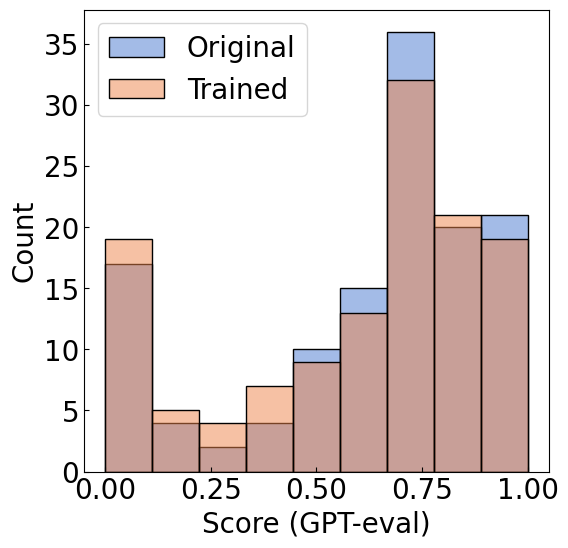

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set_style("whitegrid")
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [6, 6]
sns.set_palette("muted")
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
df=pd.DataFrame(comparison_list)
sns.histplot(df["Score (original)"],alpha=0.5,label="Original")
sns.histplot(df["Score (trained)"],alpha=0.5,label="Trained")
plt.legend()
plt.xlabel("Score (GPT-eval)")

In [23]:
df.describe()

,Score (original),Score (trained)
count,129.000000,129.000000
mean,0.609302,0.580620
std,0.294598,0.302871
min,0.000000,0.000000
25%,0.500000,0.400000
50%,0.700000,0.700000
75%,0.800000,0.800000
max,1.000000,1.000000


In [24]:
df

,Question,Answer,Original,Score (original),Trained,Score (trained)
0,How did breast cancer cell tubulins behave on ...,The tubulins extracted from breast cancer cell...,"Ah, an interesting question indeed! As a reno...",0.2,"I am not a breast cancer cell expert, but I c...",0.0
1,What types of bioactive metabolites can Talaro...,Talaromyces pinophilus can produce a variety o...,Talaromyces pinophilus is a species of fungus...,0.7,Talaromyces pinophilus is able to produce a v...,1.0
2,What are KATP channels?\n[Answer],KATP channels are nucleotide-gated potassium c...,KATP channels are a type of ion channel that ...,0.7,KATP channels are nucleotide-gated potassium ...,0.7
3,Why is it difficult to treat Pseudomonas aerug...,It is difficult to treat Pseudomonas aeruginos...,Pseudomonas aeruginosa is a highly adaptable ...,0.9,Pseudomonas aeruginosa is a very adaptable ba...,0.7
4,How does zinc modulate Aβ aggregation?\n[Answer],Zinc coordinates with 3 histidine residues and...,Zinc is a divalent cation that plays a crucia...,0.7,Zinc ions are coordinated to the three histid...,0.3
...,...,...,...,...,...,...
124,How does ultrasound velocity relate to tempera...,Research has shown that ultrasound velocity va...,Ultrasound velocity is directly related to te...,0.0,Ultrasound velocity is directly related to te...,0.7
125,Why is adaptivity important for life’s surviva...,Adaptivity is imperative for life’s survival i...,Adaptivity is essential for life's survival b...,1.0,Adaptivity is important for life’s survival b...,1.0
126,What mechanism does AFM-IR use to detect molec...,"According to the text, AFM-IR detects molecula...",AFM-IR uses the mechanical displacement of a ...,0.8,AFM-IR (Atomic Force Microscopy - Infrared) i...,0.7
127,How have popular computer vision neural networ...,Popular computer vision neural networks have b...,Popular computer vision neural networks have ...,0.7,1. Upscaling: Many neural networks that have b...,0.9


# comp 7b

In [25]:

res_dir="bayes/results/1113optuna_gpt"
json_files = glob.glob(res_dir+'/*.json')
res_list=[]
found=False
for json_file in json_files:
    res=json.load(open(json_file))
    for record in res:

        if record["n_contexts_dict"]["Abstract (target)"]!=1:
            continue
        if record["n_contexts_dict"]['Introduction (target)']!=250:
            continue
        if record["n_contexts_dict"]['Introduction-multi (target)']!=750:
            continue
        if record["epoch"]!=2:
            continue
        if record["model_size"]!=7:
            continue



        found=True
        found_record=record
        break

    if found:
        break
found_record

{'bit': 16,
 'n_contexts_dict': {'Abstract (target)': 1,
  'Introduction (target)': 250,
  'Introduction-multi (target)': 750,
  'Conclusion (target)': 1,
  'Abstract (irrelevant 1)': 1,
  'Introduction (irrelevant 1)': 1,
  'Introduction-multi (irrelevant 1)': 1,
  'Conclusion (irrelevant 1)': 1,
  'Introduction (irrelevant 2)': 1},
 'n_instructions': 1,
 'n_mmlu_instructions': 1,
 'model_name': 'meta-llama/Llama-2-7b-chat-hf',
 'target_layers': ['lm_head', 'v_proj', 'o_proj', 'gate_proj', 'up_proj'],
 'per_device_train_batch_size': 1,
 'r': 100,
 'lr': 0.0003079791789368081,
 'lora_alpha': 300,
 'total_epochs': 4,
 'inner_epochs': 1,
 'model_dir': 'model/1113optuna/',
 'model_size': 7,
 'initial_eval': False,
 'dataset': '',
 'score': 0.1450532374688241,
 'epoch': 2,
 'loss_dict': {'0': {'loss': 1.8736793415988284},
  '1': {'loss': 0.970376700428716}},
 'pred_log': [{'problem': 'You are a great scientist. Answer the following question:\n[Question] Which specific metal pollutants can 

In [26]:
qa_log=copy.deepcopy(found_record['pred_log'])
for qa in tqdm(qa_log):
    qa["problem"]=qa["problem"].replace("You are a great scientist. Answer the following question:\n[Question]","").strip()
    if qa["question_type"]=="original":
        if qa["type"]=="gen":
            score=eval(qa,eval_dict)
            qa["score_gpt"]=score
    qa["problem"]=qa["problem"].replace("You are a great scientist. Answer the following question:\n[Question]","").strip()
    if qa["question_type"]=="original":
        if qa["type"]=="gen":
            score=eval(qa,eval_dict)
            qa["score_gpt"]=score

100%|██████████| 300/300 [00:00<00:00, 134937.39it/s]


In [27]:

#initial eval
res_dir="bayes/results/1113initial_eval"
json_files = glob.glob(res_dir+'/*.json')
res_list=[]
found=False
for json_file in json_files:
    res=json.load(open(json_file))

    for record in res:
        print(record["model_size"])
        if record["model_size"]!=7:
            continue
        if record["score"]<0.1:
            continue

        original_model_record=record
        found=True
        break

    if found:
        break

original_model_record

7


{'bit': 16,
 'n_irrelevant_texts': 0,
 'lola_layer_dict': {'embed_tokens': False,
  'lm_head': True,
  'q_proj': False,
  'k_proj': False,
  'v_proj': True,
  'o_proj': True,
  'gate_proj': True,
  'up_proj': True,
  'down_proj': False},
 'num_train_contexts': 1,
 'num_train_instructions': 1,
 'model_name': 'meta-llama/Llama-2-7b-chat-hf',
 'target_layers': ['lm_head', 'v_proj', 'o_proj', 'gate_proj', 'up_proj'],
 'train_context_dict': {},
 'per_device_train_batch_size': 1,
 'r': 100,
 'lr': 0.00030879500439528557,
 'lora_alpha': 300,
 'total_epochs': 0,
 'inner_epochs': 0,
 'dataset': 'Intro(mult)+QA',
 'model_dir': 'model/1113initial_eval/',
 'n_lit': 0,
 'model_size': 7,
 'initial_eval': True,
 'score': 0.401064519005243,
 'epoch': 0,
 'loss_dict': {},
 'pred_log': [{'problem': 'You are a great scientist. Answer the following question:\n[Question] Which specific metal pollutants can impact human skin?\nChoices:\n1. These toxic compounds are directly implicated in skin pathological p

In [28]:
qa_log_ori=copy.deepcopy(original_model_record['pred_log'])
for qa in tqdm(qa_log_ori):
    qa["problem"]=qa["problem"].replace("You are a great scientist. Answer the following question:\n[Question]","").strip()
    if qa["question_type"]=="original":
        if qa["type"]=="gen":
            score=eval(qa,eval_dict)
            qa["score_gpt"]=score

100%|██████████| 300/300 [00:00<00:00, 202362.69it/s]


In [29]:

with open(eval_dict_path,"w") as f:
    json.dump(eval_dict,f,indent=4)

In [37]:
qa_df=pd.DataFrame(qa_log)
qa_df.to_csv("bayes/results/gpteval/7b_full.csv")

In [30]:

comparison_list=[]

for i in range(len(qa_log)):
    if qa_log[i]["type"]!="gen":
        continue

    prob_dict={
        "Question":qa_log[i]["problem"],
        "Answer":qa_log[i]["answer"],
        "Original":qa_log_ori[i]["pred"],
        "Score (original)":qa_log_ori[i]["score_gpt"]/10,
        "Trained":qa_log[i]["pred"],
        "Score (trained)":qa_log[i]["score_gpt"]/10,
    }
    comparison_list.append(prob_dict)

Text(0.5, 0, 'Score (GPT-eval)')

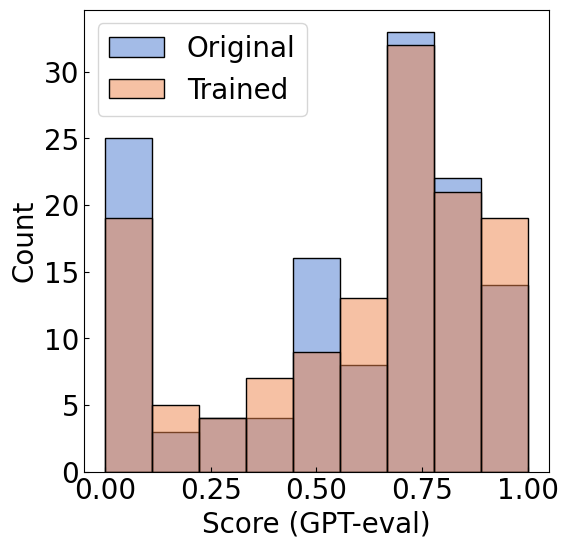

In [31]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set_style("whitegrid")
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [6, 6]
sns.set_palette("muted")
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
df=pd.DataFrame(comparison_list)
sns.histplot(df["Score (original)"],alpha=0.5,label="Original")
sns.histplot(df["Score (trained)"],alpha=0.5,label="Trained")
plt.legend()
plt.xlabel("Score (GPT-eval)")

In [32]:

df.describe()

,Score (original),Score (trained)
count,129.000000,129.000000
mean,0.547287,0.580620
std,0.314761,0.302871
min,0.000000,0.000000
25%,0.400000,0.400000
50%,0.700000,0.700000
75%,0.800000,0.800000
max,1.000000,1.000000


In [34]:
df.to_csv("bayes/results/gpteval/7b.csv")